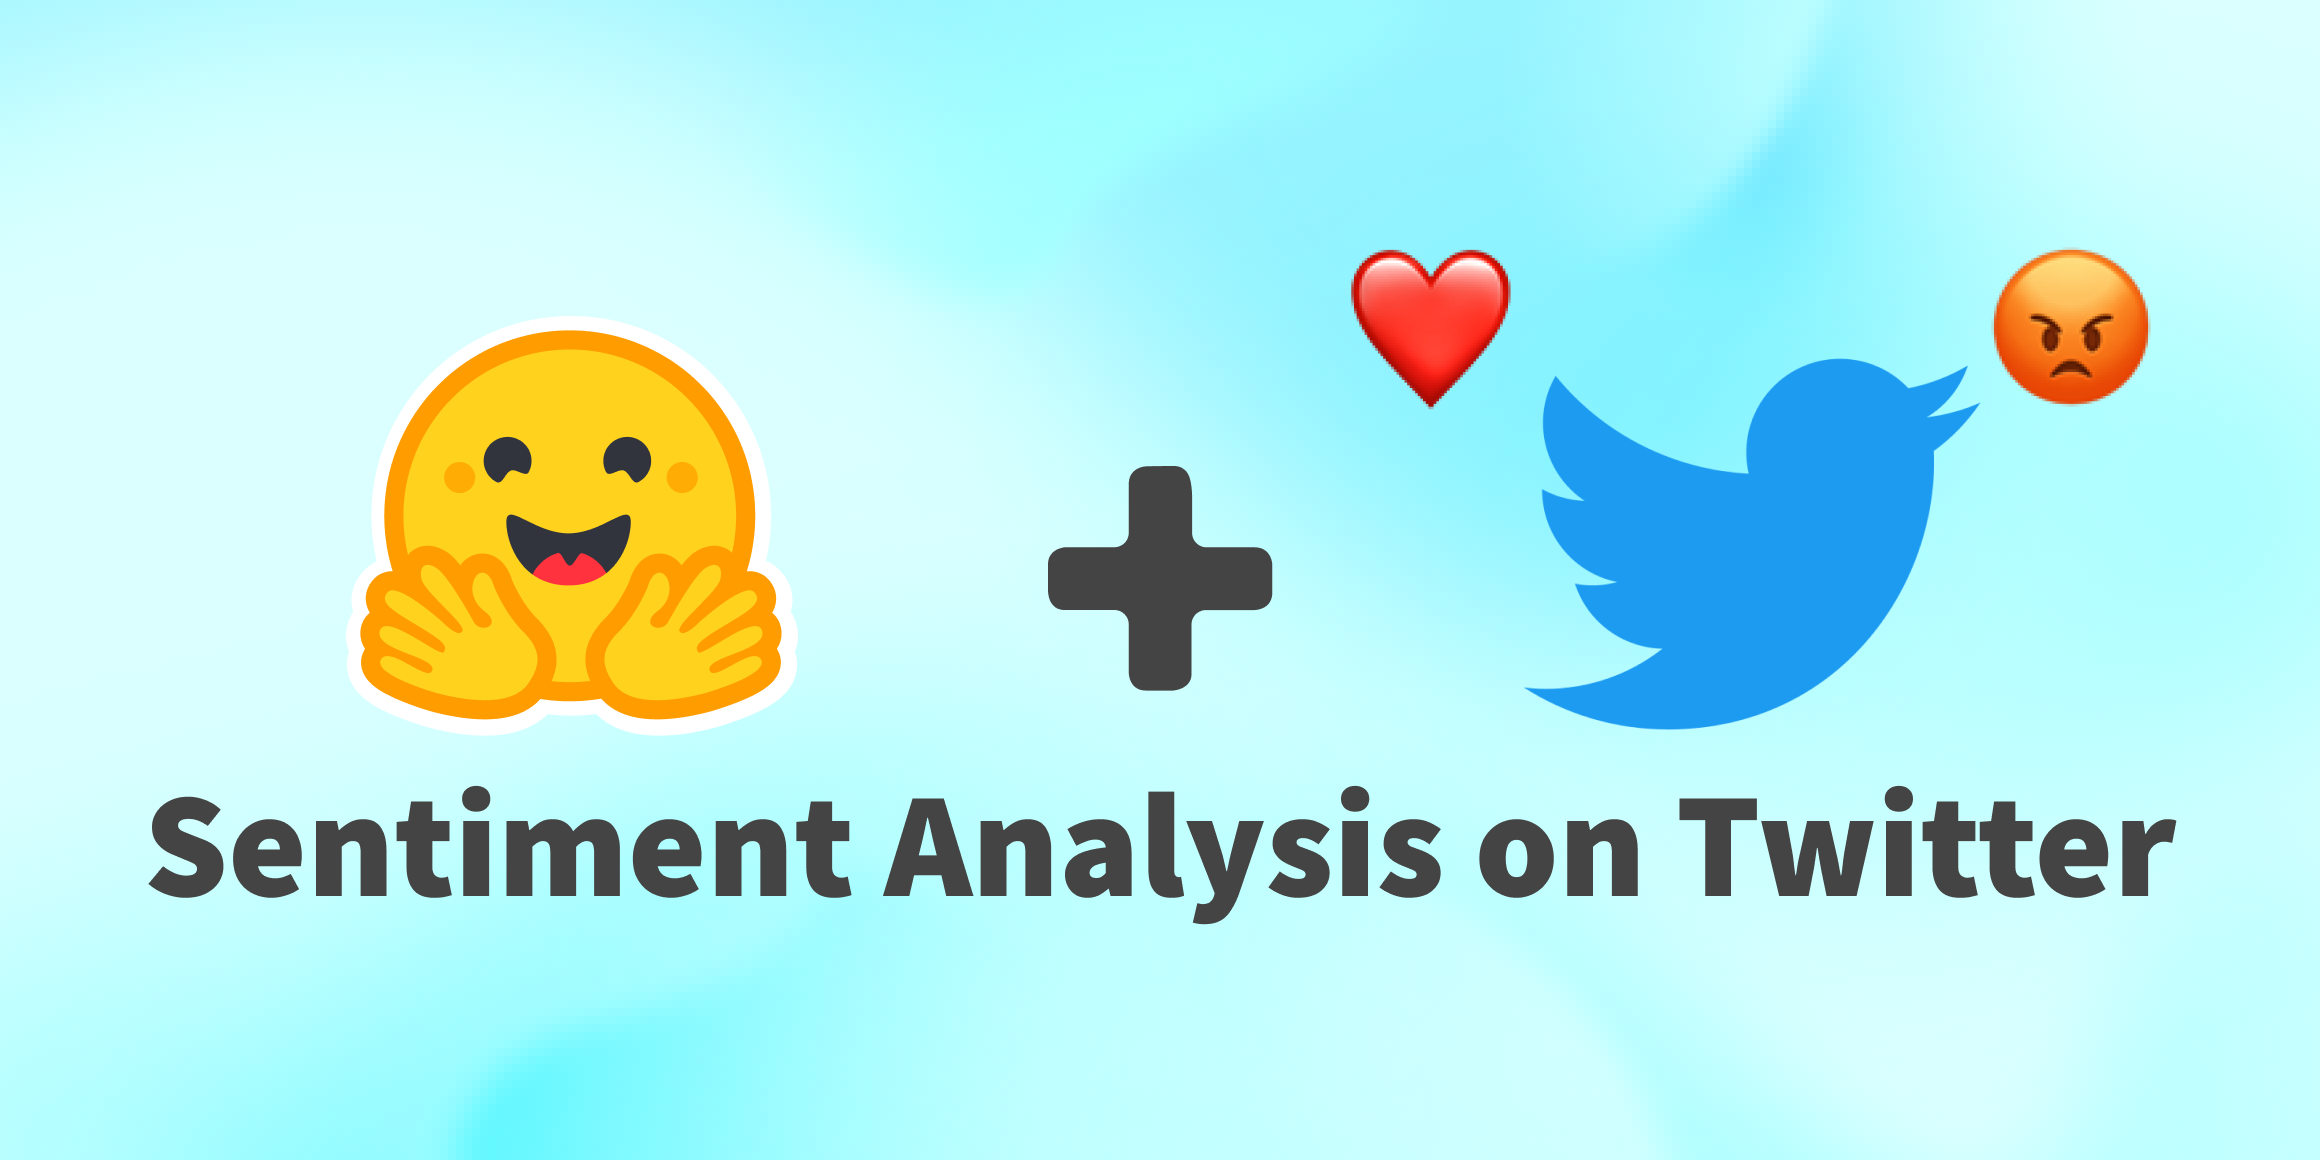

## **Business Understanding**

The purpose of this project is to provide stakeholders (Apple and Google) with an enhanced customer understanding.  By analyzing tweet sentiment, the stakeholder will gain deeper insights into customer preferences, needs, and expectations.  This will allow them to tailor their products and services to meet customer demands more effectively.  This project will also allow stakeholders to identify negative posts from cusomers and address them as quickly as possible.  This will allow them to improve the overall satisfaction levels of customers and have lower turnover.

## **Data Understanding**

The [dataset](https://data.world/crowdflower/brands-and-product-emotions) comes from [CrowdFlower](https://visit.figure-eight.com/People-Powered-Data-Enrichment_T) via data.world.  Contributors evaluated 9,000 tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion.

The data are suitable for this project because the purpose of this project is to analyze the sentiment of text.  This dataset provides real example of customers trying to interface with the companies that made their product.  

The features used in this analysis were the text in the tweets and the sentiment provided by the crowd.  

In [66]:
#Import Necessary Libraries
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from nltk import FreqDist, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from wordcloud import WordCloud

import itertools
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns

!pip install nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Data Understanding**

### **Inspect, Column Cleaning, One-Hot Encoding**

First, I explored the data.  I saw that the data were sorted into three columns.  A column with the contents of a tweet, an emotion found in the tweet determined by the crowd, and who the emotion was directed at.  I dropped the column about who the emotion is directed at because it is missing 6,000 entries and for this analysis I'm not interested in who the data is directed at.  I'm only interested in the sentiment of the tweet. I also renamed target column to make it shorter created unique columns for each emotion being expressed and applied a binary identifier for analysis.

In [67]:
#Import Data
df = pd.read_csv('https://raw.githubusercontent.com/josh-g-grimes/Twitter-Sentiment-NLP/main/data.csv', encoding='latin-1')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [69]:
#Inspect the Columns
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [70]:
#I renamed the column so it would be shorter and match the business understanding
df = df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product": "tweet_sentiment"})

In [71]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,tweet_sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


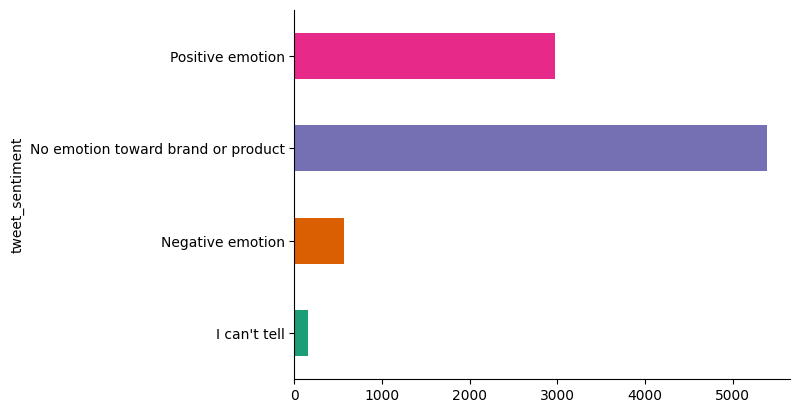

In [72]:
#Look at the distribution of emotions that are directed at brands or products
df.groupby('tweet_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [73]:
#For this analysis I'm only interested in evaluating the sentiment of the tweet and not who it is directed at, therefore I dropped that column
df.drop(columns=['emotion_in_tweet_is_directed_at'], inplace=True)

In [74]:
#I created a column for each type of sentiment expressed above (Positive, Negative, Neutral, Can't Tell) and assigned it a 1 if that tweet goes in that column
for emotion in df['tweet_sentiment'].unique():
    df[emotion] = df['tweet_sentiment'].apply(lambda x: 1 if x == emotion else 0)

In [75]:
#I dropped the tweet_sentiment column since I have the sentiment indicated with a 1
df.drop(columns=['tweet_sentiment'], inplace=True)

In [76]:
#Shorten the column name
df = df.rename(columns={"No emotion toward brand or product": "No emotion"})

### **Understanding Text Changes Using Word Clouds**

In this section I create a directory for each sentiment expressed in the tweet.  I join all of the text from all the tweets in each sentiment in the directory so I can create bags of words using all of the words for that sentiment.  I then create Word Clouds to see if there is a difference in the words before and after normalizing, tokenizing lemmatization, and removing stop words.

In [77]:
#Create an empty dct to store a dataframe for each sentiment
emotion_df = {}

for emotion in df.columns[1:]:
  #Creates a key and value of only that sentiment
    emotion_df[emotion] = df[df[emotion] == 1]['tweet_text']

In [78]:
# Convert all elements of the series to strings and replace NaN with empty strings
No_emotion_text = " ".join(str(x) for x in emotion_df['No emotion'].fillna(''))
Negative_emotion_text = " ".join(str(x) for x in emotion_df['Negative emotion'].fillna(''))
Positive_emotion_text = " ".join(str(x) for x in emotion_df['Positive emotion'].fillna(''))
Cant_tell_emotion_text = " ".join(str(x) for x in emotion_df['I can\'t tell'].fillna(''))

In [79]:
print('No Emotion Length: ', len(No_emotion_text))
print('Negative Emotion Length: ', len(Negative_emotion_text))
print('Positive Emotion Length: ', len(Positive_emotion_text))
print('Cant Tell Emotion Length: ', len(Cant_tell_emotion_text))

No Emotion Length:  566745
Negative Emotion Length:  62954
Positive Emotion Length:  317331
Cant Tell Emotion Length:  16376


Text(0.5, 1.0, 'No Emotion')

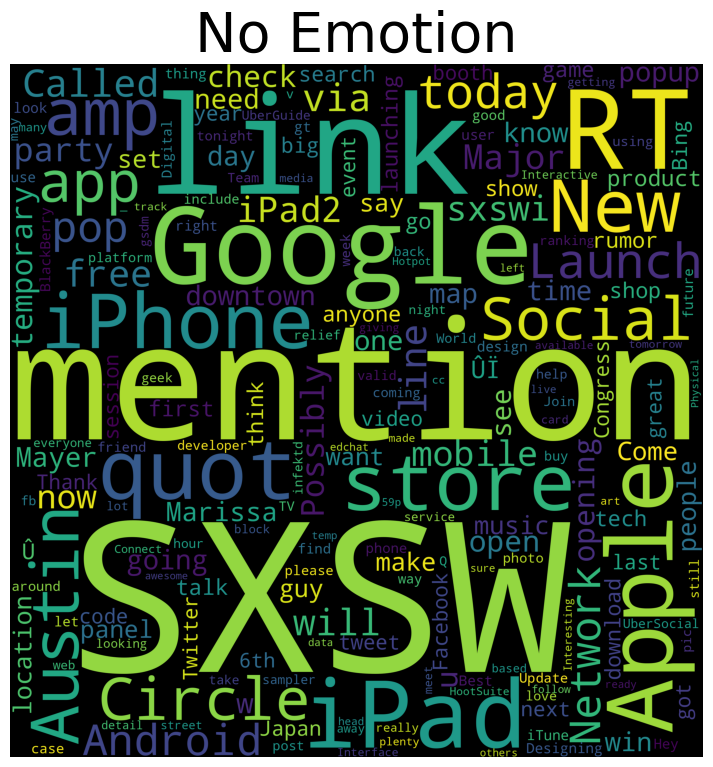

In [80]:
#Creates a Word Cloud for the most common words in tweets with No Emotion towards a product
plt.figure(figsize=(10, 9))
cloud = WordCloud(background_color='black', collocations=False, width=2500, height=2500).generate(No_emotion_text)
plt.imshow(cloud)
plt.axis('off')
plt.title('No Emotion', fontsize=40)

In [81]:
#Removes special characters, and numbers
def the_cleaner(text):

   text_replace = text.replace('\\r', ' ').replace('\\n', ' ').replace('\\', '').split()
   text_strip = [re.sub(r"\([^()]*\)", "", i) for i in text_replace]
   cleaned_text = " ".join([x for x in text_strip if x.isalpha() and len(x) > 1])

   return cleaned_text

In [82]:
No_emotion_text = the_cleaner(No_emotion_text)
Negative_emotion_text = the_cleaner(Negative_emotion_text)
Positive_emotion_text = the_cleaner(Positive_emotion_text)
Cant_tell_emotion_text = the_cleaner(Cant_tell_emotion_text)

In [83]:
def lem_process_doc(text):

    text = text.lower() #lowercase all the text

    stop_words = stopwords.words('english') #import stop word list
    twitter_stop_words = ['RT', 'twitter']
    stop_words_modified = list(itertools.chain(twitter_stop_words, stop_words)) #combining stop words and twitter stop words

    wnl = WordNetLemmatizer() ###Lemmatize words
    doc_norm = [tok for tok in word_tokenize(text) if ((tok.isalpha()) & (tok not in stop_words_modified))] ###Tokenize Words

    return " ".join([wnl.lemmatize(tok) for tok in doc_norm])

In [84]:
No_emotion_text = lem_process_doc(No_emotion_text)
Negative_emotion_text = lem_process_doc(Negative_emotion_text)
Positive_emotion_text = lem_process_doc(Positive_emotion_text)
Cant_tell_emotion_text = lem_process_doc(Cant_tell_emotion_text)

Text(0.5, 1.0, 'No Emotion')

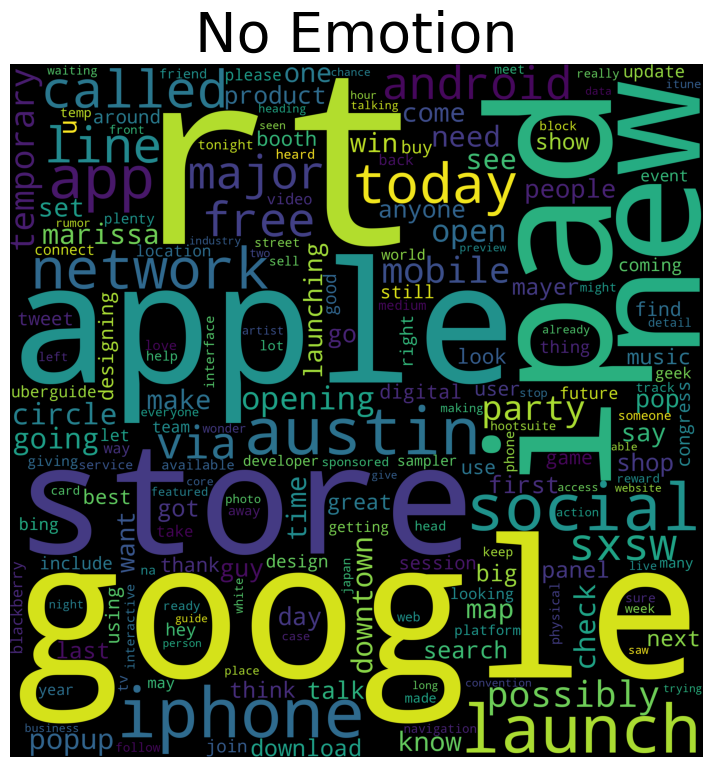

In [85]:
#Creates a Word Cloud for the most common words in tweets with No Emotion towards a product
plt.figure(figsize=(10, 9))
cloud = WordCloud(background_color='black', collocations=False, width=2500, height=2500).generate(No_emotion_text)
plt.imshow(cloud)
plt.axis('off')
plt.title('No Emotion', fontsize=40)

### **Understanding Optimal Stop Word List**

In this section I create a stopword list using the intersection of common words from each of the sentiments so I can remove those to understand better the differences between the words used in each sentiment.

In [86]:
#initialize dict to store text values
emotion_word_counts = {}

#looping through all target classes
for emotion in df.columns[1:]:

  #saving preprocess text to a variable
  emotion_preprocessed_text = " ".join(str(text) for text in df[df[emotion] == 1]['tweet_text'])

  #creating a freq dict
  emotion_freq_dict = FreqDist(emotion_preprocessed_text.split())

  #storing emotion's freqdict in intial dictoniary for quick access
  emotion_word_counts[emotion] = emotion_freq_dict

In [87]:
#find the most frequent words
def getting_stops(freq_dist, top_n):
  words = []
  for word, frequency in freq_dist.most_common(top_n):
    words.append(word)
  return words

In [88]:
#Create a list of the most frequent words shared by each of the emotion sentiments
word_list = []
for emotion in emotion_word_counts.keys():
  word_list.append(getting_stops(emotion_word_counts[emotion], 15000))

stops = list(set.intersection(*map(set, word_list)))

In [89]:
def lem_process_doc(text):

    text = text.lower() #lowercase all the text

    stop_words = stopwords.words('english') #import stop word list
    twitter_stop_words = ['rt', 'twitter', 'mention', 'quot', 'sxsw', 'sxswi', 'austin', 'android', 'marissa', 'circle']
    stop_words_modified = list(itertools.chain(twitter_stop_words, stop_words, stops)) #combining stop words from nltk, twitter stop words, and the intersection of words

    wnl = WordNetLemmatizer() ###Lemmatize words
    doc_norm = [tok for tok in word_tokenize(text) if ((tok.isalpha()) & (tok not in stop_words_modified))] ###Tokenize Words

    return " ".join([wnl.lemmatize(tok) for tok in doc_norm])

In [90]:
No_emotion_text = lem_process_doc(No_emotion_text)
Negative_emotion_text = lem_process_doc(Negative_emotion_text)
Positive_emotion_text = lem_process_doc(Positive_emotion_text)
Cant_tell_emotion_text = lem_process_doc(Cant_tell_emotion_text)

Text(0.5, 1.0, 'No Emotion')

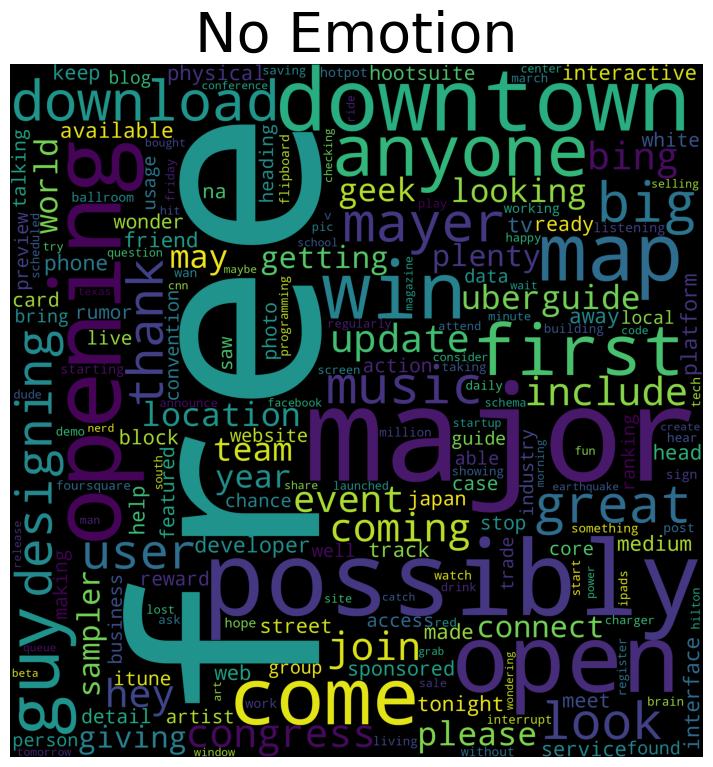

In [91]:
#Creates a Word Cloud for the most common words in tweets with No Emotion towards a product
plt.figure(figsize=(10, 9))
cloud = WordCloud(background_color='black', collocations=False, width=2500, height=2500).generate(No_emotion_text)
plt.imshow(cloud)
plt.axis('off')
plt.title('No Emotion', fontsize=40)

Text(0.5, 1.0, 'Positive Emotion')

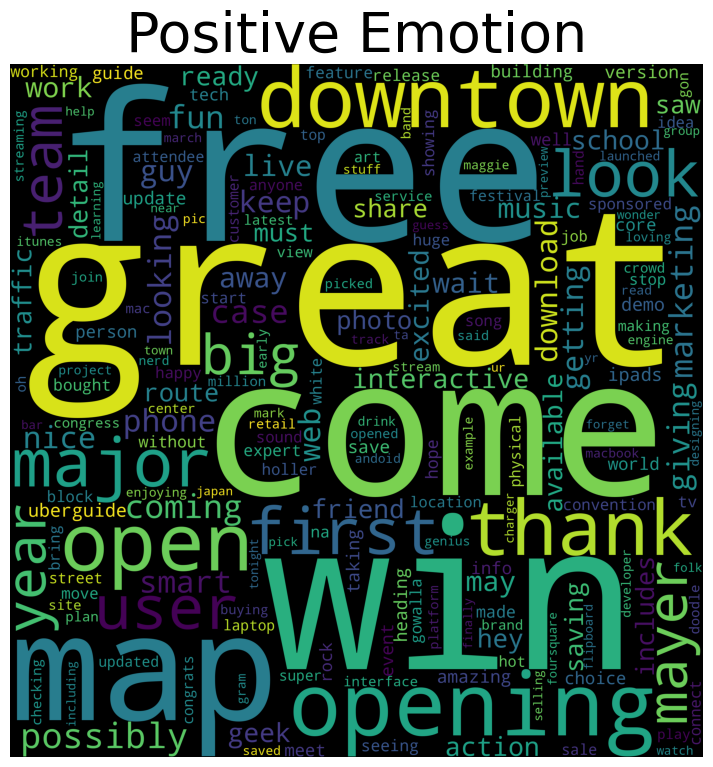

In [92]:
#Creates a Word Cloud for the most common words in tweets with No Emotion towards a product
plt.figure(figsize=(10, 9))
cloud = WordCloud(background_color='black', collocations=False, width=2500, height=2500).generate(Positive_emotion_text)
plt.imshow(cloud)
plt.axis('off')
plt.title('Positive Emotion', fontsize=40)

Text(0.5, 1.0, 'Negative Emotion')

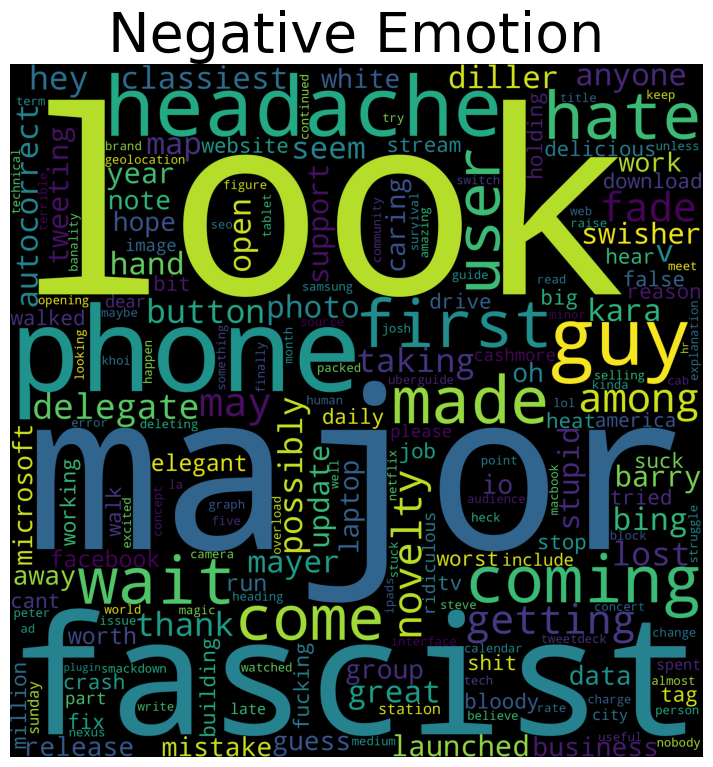

In [93]:
#Creates a Word Cloud for the most common words in tweets with No Emotion towards a product
plt.figure(figsize=(10, 9))
cloud = WordCloud(background_color='black', collocations=False, width=2500, height=2500).generate(Negative_emotion_text)
plt.imshow(cloud)
plt.axis('off')
plt.title('Negative Emotion', fontsize=40)

Text(0.5, 1.0, "Can't Tell")

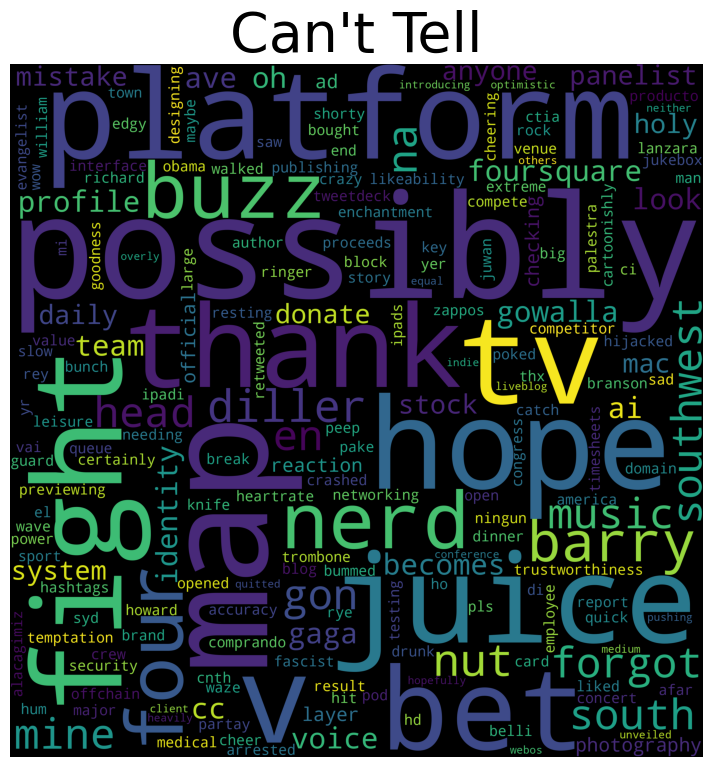

In [94]:
#Creates a Word Cloud for the most common words in tweets with No Emotion towards a product
plt.figure(figsize=(10, 9))
cloud = WordCloud(background_color='black', collocations=False, width=2500, height=2500).generate(Cant_tell_emotion_text)
plt.imshow(cloud)
plt.axis('off')
plt.title("Can't Tell", fontsize=40)

### **Data Preparation**

My data understanding showed that I need to lowercase, lemmatize, and tokenize my words as well as removing standard english stop words, words related to using twitter, and the intersection of the most common words in each sentiment.  In this section, I will create a train-test-split of the data and then apply the preprocessing steps I did in the data understanding section to the training data only to avoid data leakage.

In [95]:
#I split the data like this to keep the target classes in the same dataframe as the text in order to optimize the stop word list
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [96]:
#This cleans and normalizes the text in the training and test data separately and saves the text as a new column
# Check for float values in 'tweet_text' column of both DataFrames
print(df_train['tweet_text'].apply(type).value_counts())
print(df_test['tweet_text'].apply(type).value_counts())

# Convert any float values to string before applying the_cleaner function
df_train['tweet_text'] = df_train['tweet_text'].astype(str)
df_test['tweet_text'] = df_test['tweet_text'].astype(str)

#Apply the cleaner function I created in the Data Understanding Section
df_train['txt'] = df_train.tweet_text.apply(lambda x: the_cleaner(x))
df_test['txt'] = df_test.tweet_text.apply(lambda x: the_cleaner(x))

tweet_text
<class 'str'>      7273
<class 'float'>       1
Name: count, dtype: int64
tweet_text
<class 'str'>    1819
Name: count, dtype: int64


In [97]:
#Apply the lemmatization function I created in the Data Understanding Section
df_train['txt'] = df_train.tweet_text.apply(lambda x: lem_process_doc(x))
df_test['txt'] = df_test.tweet_text.apply(lambda x: lem_process_doc(x))

In [98]:
#Split training data by target class into individual dataframes
emotion_dfs = {}

for emotion in df.columns[1:]:
  emotion_dfs[emotion] = df_train[df_train[emotion] == 1]

In [99]:
#Extract text from each dictionary value and creat frequency distribution objects as word counts
emotion_freq_dist = {}

for emotion in emotion_dfs.keys():
  all_emotion_text = " ".join(emotion_dfs[emotion].txt)
  emotion_freq_dist[emotion] = FreqDist(all_emotion_text.split())

In [100]:
#Loop through each FreqDist for each emotion, extract the top words, add them to a list and find the intersection
top_words = []

for emotion in emotion_freq_dist.keys():
  emotion_words = emotion_freq_dist[emotion].most_common(15000)
  top_words.append(set([word for word, _ in emotion_words]))

stop_words = list(set.intersection(*top_words))


In [101]:
#Eliminate words in the training and test data that are on the stop word list
def stopping(text, stops):
  text_split = text.split()
  updated_text = [word for word in text_split if word not in stops]

  return " ".join(updated_text)

#assign the preprocessed text to the X variable
X_train = df_train.txt.apply(lambda x: stopping(x, stop_words))
X_test = df_test.txt.apply(lambda x: stopping(x, stop_words))

In [102]:
#Assign the target Variables
y_train = df_train.loc[:, emotion_freq_dist.keys() ]
y_test = df_test.loc[:, emotion_freq_dist.keys() ]

### **Modeling**

The machine learning algorithms I used for this multi-label classification model are OneVsRestClassifier and ClassifierChain.  

I chose to use OneVsRestClassifier because it is a common algorithm used for multi-class classification.  It splits the multi-class dataset into multiple binary classification problems.  The binary classifier is trained on each binary classification problem and then predictions are made using the model that is the most confident.  I created models using three differnt binary classifiers (Logistic Regression, Random Forest, and SVM) and also used count vecorization and tdidf vecotrization on each of the different binary classifiers.

I chose to use the ClassifierChain algorithm because it is another algorithm used for multi-classification models.  This algorithm uses the correlation among the classes and builds a chain of binary classifiers.  The models get a prediction from the preceding model in the chain as a feature.

I used Hamming Loss as the metric to evaluate my models because it is typically used for multi-classification models.  Hamming loss reports how many times on average, the relevance of an example to a class label is incorrectly predicted. It takes into account when an incorrect label is predicted and when a relavent label is not predicted and normalizes it over the total number of classes and examples.  The lower the Hamming Loss, the better the models performance.

The best model was the OneVsRestClassifier Algorithm using a logistic rogression baseline model and count vectorization.

In [103]:
#Takes in a fitted model, dictionary, and description of the model and returns an updated dictionary that will be used to evaluate model results
models_dct = {'model': [], 'hamming_loss': [], 'model_type': []}

def model_update(model, dct, model_type):
  #The to_frame() method was missing the name parameter. Adding it in should fix the issue.
  #The code was previously only predicting on the first row of X_test. Updated to predict on the entire dataframe.
  y_pred = model.predict(X_test)
  ham_loss = hamming_loss(y_test, y_pred)
  models_dct['model'].append(model)
  models_dct['hamming_loss'].append(ham_loss)
  models_dct['model_type'].append(model_type)

  print(f'{model_type}: {ham_loss}')

In [104]:
pipe_OVRC_lg = Pipeline([('tfidf', TfidfVectorizer()),('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))])
pipe_OVRC_lg.fit(X_train, y_train)
model_update(pipe_OVRC_lg, models_dct, 'Logistic Regression')

pipe_OVRC_rf = Pipeline([('tfidf', TfidfVectorizer()),('clf', OneVsRestClassifier(RandomForestClassifier()))])
pipe_OVRC_rf.fit(X_train, y_train)
model_update(pipe_OVRC_rf, models_dct, 'Random Forest')

pipe_OVRC_svc = Pipeline([('tfidf', TfidfVectorizer()),('clf', OneVsRestClassifier(LinearSVC()))])
pipe_OVRC_svc.fit(X_train, y_train)
model_update(pipe_OVRC_svc, models_dct, 'Linear SVC')

Logistic Regression: 0.17605827377680044
Random Forest: 0.1759208356239692
Linear SVC: 0.17715777899945026


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [105]:
pipe_OVRC_lg_2 = Pipeline([('cv', CountVectorizer()),('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))])
pipe_OVRC_lg_2.fit(X_train, y_train)
model_update(pipe_OVRC_lg_2, models_dct, 'Logistic Regression 2')

pipe_OVRC_rf_2 = Pipeline([('cv', CountVectorizer()),('clf', OneVsRestClassifier(RandomForestClassifier()))])
pipe_OVRC_rf_2.fit(X_train, y_train)
model_update(pipe_OVRC_rf_2, models_dct, 'Random Forest 2')

pipe_OVRC_svc_2 = Pipeline([('cv', CountVectorizer()),('clf', OneVsRestClassifier(LinearSVC()))])
pipe_OVRC_svc_2.fit(X_train, y_train)
model_update(pipe_OVRC_svc_2, models_dct, 'Linear SVC 2')

Logistic Regression 2: 0.17344694887300716
Random Forest 2: 0.18086860912589334


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVC 2: 0.18155579989004947


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [106]:
pipe_CC_lg = Pipeline([('tfidf', TfidfVectorizer()),('clf', ClassifierChain(LogisticRegression(solver='liblinear')))])
pipe_CC_lg.fit(X_train, y_train)
model_update(pipe_CC_lg, models_dct, 'Logistic Regression Chain')

pipe_CC_rf = Pipeline([('tfidf', TfidfVectorizer()),('clf', ClassifierChain(RandomForestClassifier()))])
pipe_CC_rf.fit(X_train, y_train)
model_update(pipe_CC_rf, models_dct, 'Random Forest Chain')

pipe_CC_svc = Pipeline([('tfidf', TfidfVectorizer()),('clf', ClassifierChain(LinearSVC()))])
pipe_CC_svc.fit(X_train, y_train)
model_update(pipe_CC_svc, models_dct, 'Linear SVC Chain')

Logistic Regression Chain: 0.17757009345794392
Random Forest Chain: 0.17729521715228147
Linear SVC Chain: 0.17564595931830676


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [107]:
pipe_CC_lg_2 = Pipeline([('cv', CountVectorizer()),('clf', ClassifierChain(LogisticRegression(solver='liblinear')))])
pipe_CC_lg_2.fit(X_train, y_train)
model_update(pipe_CC_lg_2, models_dct, 'Logistic Regression Chain 2')

pipe_CC_rf_2 = Pipeline([('cv', CountVectorizer()),('clf', ClassifierChain(RandomForestClassifier()))])
pipe_CC_rf_2.fit(X_train, y_train)
model_update(pipe_CC_rf_2, models_dct, 'Random Forest Chain 2')

pipe_CC_svc_2 = Pipeline([('cv', CountVectorizer()),('clf', ClassifierChain(LinearSVC()))])
pipe_CC_svc_2.fit(X_train, y_train)
model_update(pipe_CC_svc_2, models_dct, 'Linear SVC Chain 2')

Logistic Regression Chain 2: 0.1742715777899945
Random Forest Chain 2: 0.18031885651456844


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVC Chain 2: 0.1794942275975811


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


### **Evaluating Results Between Models**

In this section I plotted the hamming loss between each model type to determine which was the best model.

In [ ]:
#Store dct as a dataframe
model_data = pd.DataFrame(models_dct)

In [ ]:
ham = model_data.sort_values(by='hamming_loss').hamming_loss
mt = model_data.sort_values(by='hamming_loss').model_type

In [ ]:
#plot avg ham loss of each model
fig, ax = plt.subplots(figsize=(20,12))

sns.barplot(x=ham, y=list(range(len(ham))), orient = 'h', ax=ax)

ax.set_yticks(list(range(len(ham))))
ax.set_yticklabels(mt)

ax.set_title('Average Hamming Loss between Model Types', fontsize=30, pad=15)
ax.set_xlabel('Hamming Loss', fontsize=15)

plt.show()

### **Evaluating Best Model's Predictions**

In this section I looked at the average ham loss for each sentiment from my best performing model.

In [128]:
y_pred = pipe_OVRC_lg_2.predict(X_test) #predictions on best model

dct = {'tweet_text': [], 'actual': [], 'predicted': []}

for i in range(len(y_test)):

  dct['tweet_text'].append(X_test.iloc[i]) # Access the element using index.
  dct['actual'].append(np.array(y_test.iloc[i]))
  dct['predicted'].append(y_pred[i])

In [129]:
#Convert dct to dataframe
predictions = pd.DataFrame(dct, index=X_test.index)

In [137]:
#converts predicted arrays to list of sentiments
def labeller(arry):
  labels = []
  for i, x in enumerate(arry):
    if x == 1:
      labels.append(list(y_test.columns)[i])
  return labels

In [138]:
predictions['actual'] = predictions.actual.apply(lambda x: labeller(x)) #actual sentiments
predictions['predicted'] = predictions.predicted.apply(lambda x: labeller(x)) #predicted sentiments

In [144]:
ham_loss = [] #appending ham_loss by single row

for i in range(len(predictions)):
  # Ensure both lists have the same length before calculating Hamming loss
  if len(predictions.actual.iloc[i]) == len(predictions.predicted.iloc[i]):
    ham_loss.append(hamming_loss(predictions.actual.iloc[i], predictions.predicted.iloc[i]))
  else:
    # Handle cases with differing lengths (e.g., append a default value)
    ham_loss.append(0)

predictions['ham_loss'] = ham_loss #adding ham_loss to dataframe

In [145]:
#One hot encodes prediction dataframe
def sentiment_encoding(row, sentiment):
  if sentiment in row:
    return 1
  else:
    return 0

In [146]:
for i in emotion_freq_dist.keys():
  predictions[i] = predictions.predicted.apply(lambda x: sentiment_encoding(x, i))

In [147]:
ham_loss_by_sentiment = [] #appending ham_loss by tweet sentiment
for i in emotion_freq_dist.keys():
  ham_loss_by_sentiment.append(predictions[predictions[i] == 1].ham_loss.mean())

<ipython-input-149-dea8b690e82b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(emotion_freq_dist.keys()))


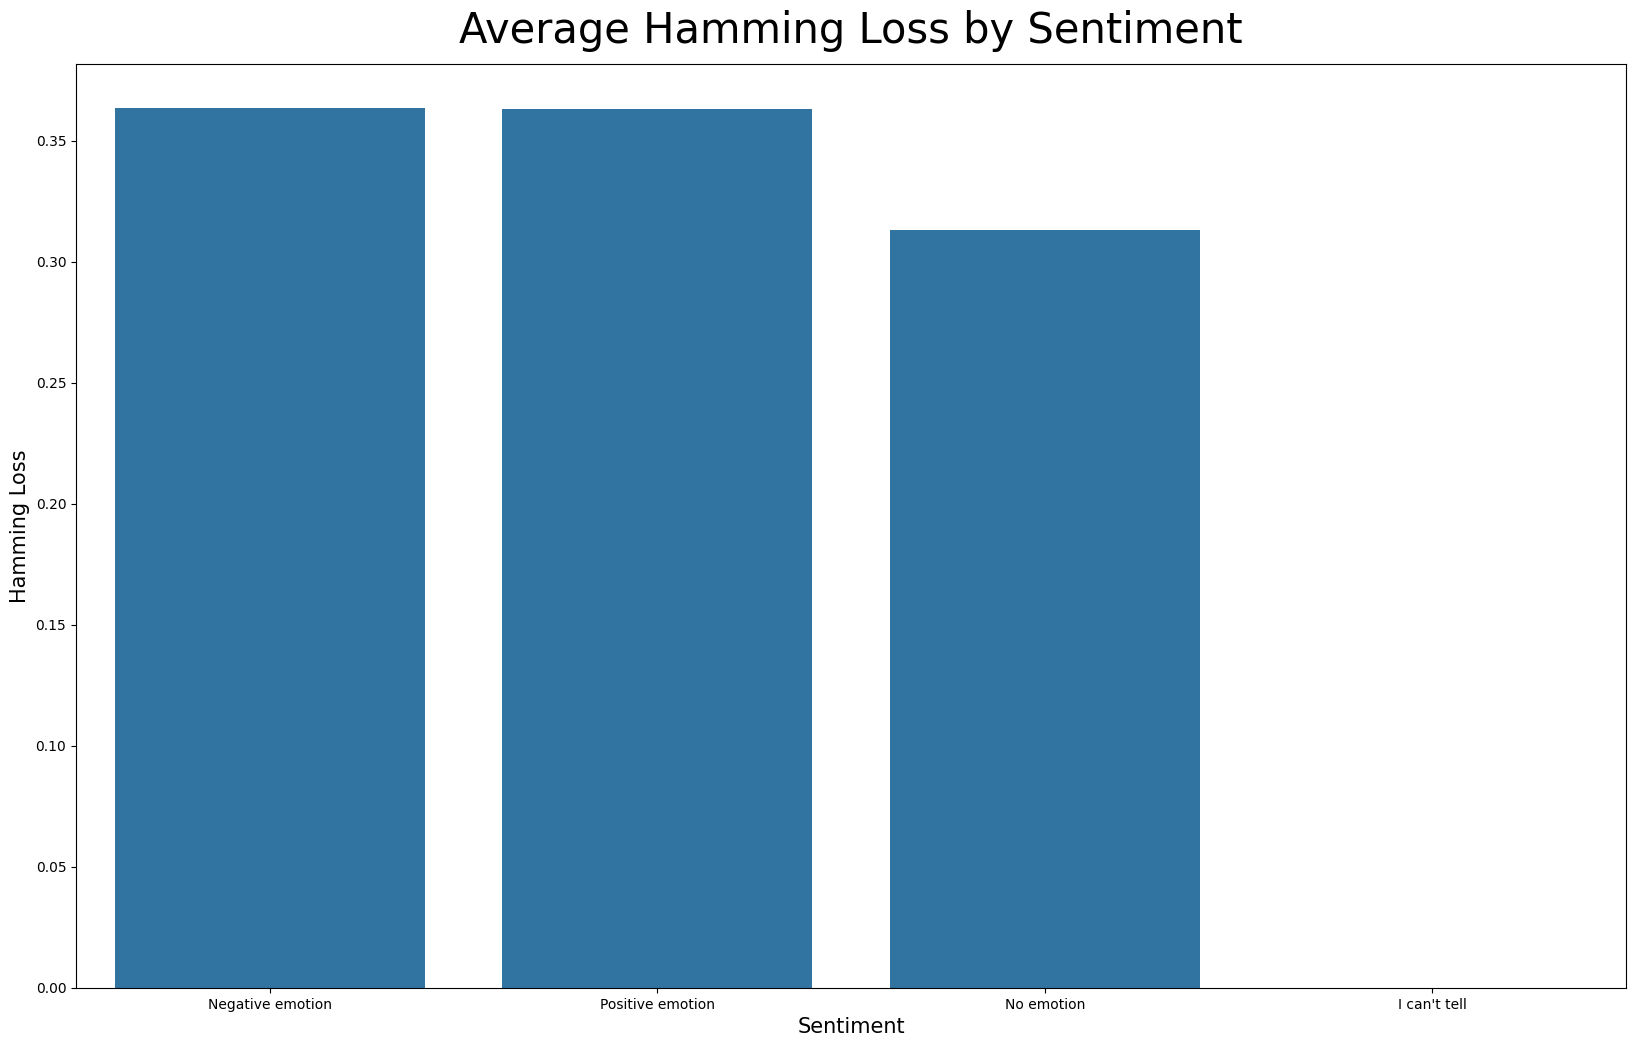

In [149]:
#plotting average hamloss by tweet sentiment
fig, ax = plt.subplots(figsize=(20,12))

# Pass data as keyword arguments
sns.barplot(x=list(range(len(ham_loss_by_sentiment))), y=ham_loss_by_sentiment, orient = 'v', ax=ax)

ax.set_title('Average Hamming Loss by Sentiment', fontsize=30, pad=15)
ax.set_xlabel('Sentiment', fontsize=15)
ax.set_ylabel('Hamming Loss', fontsize=15)
ax.set_xticklabels(list(emotion_freq_dist.keys()))
plt.show()

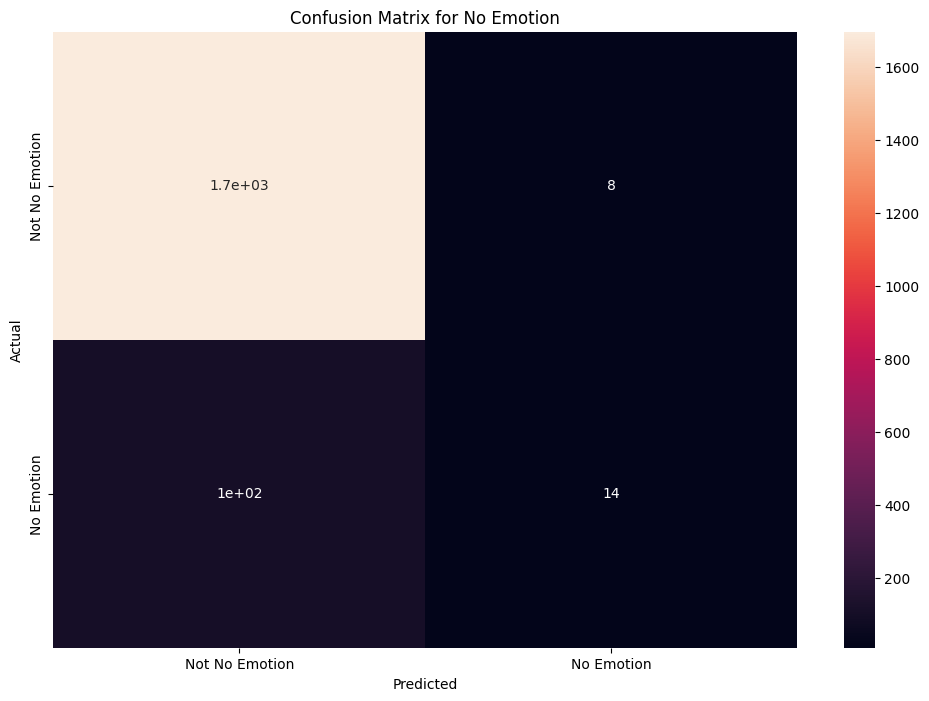

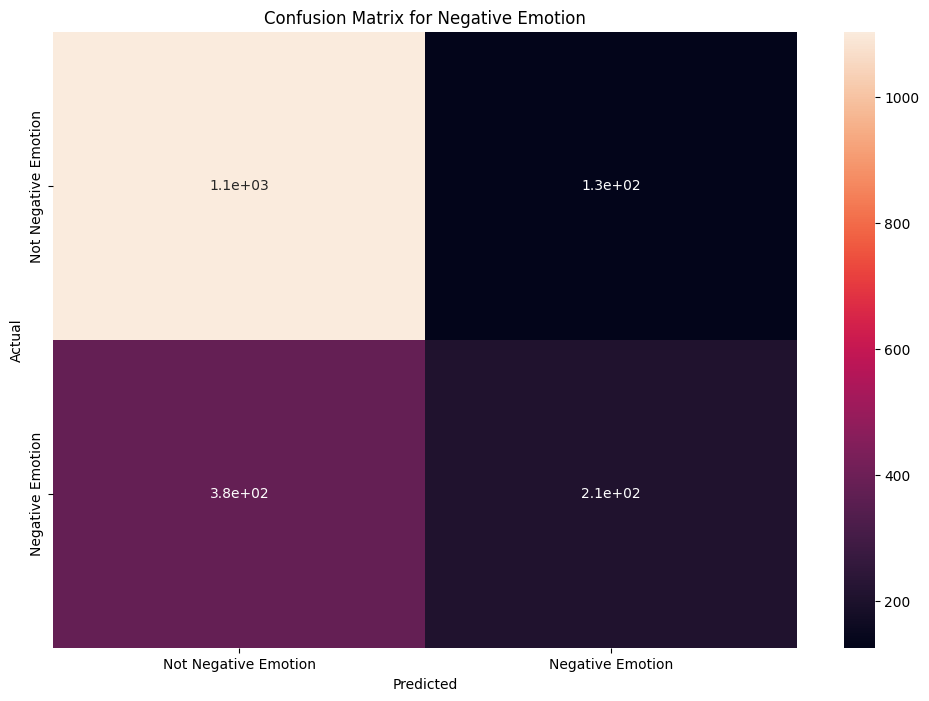

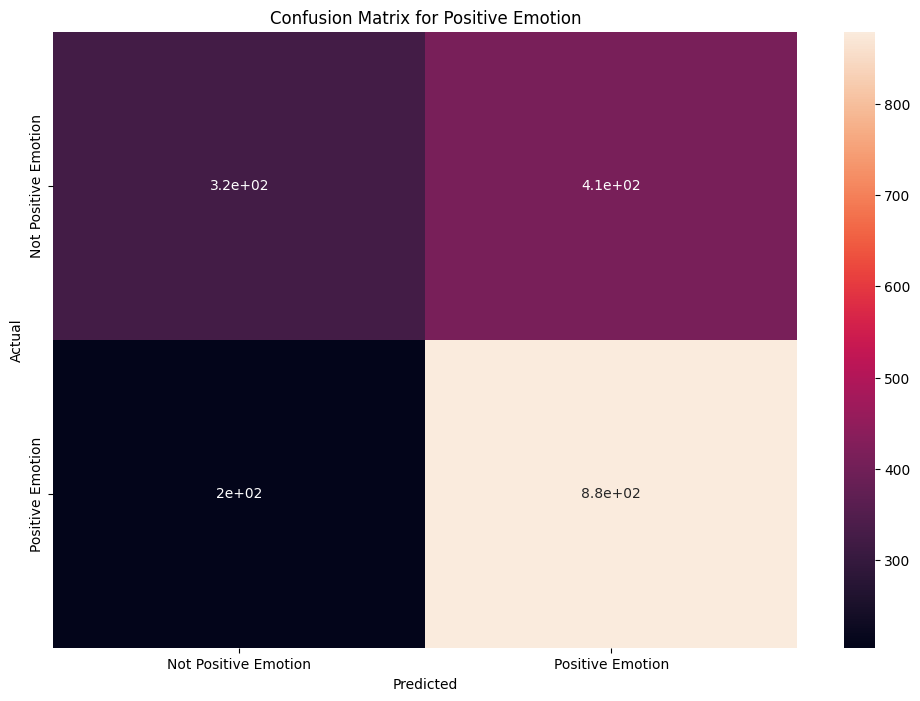

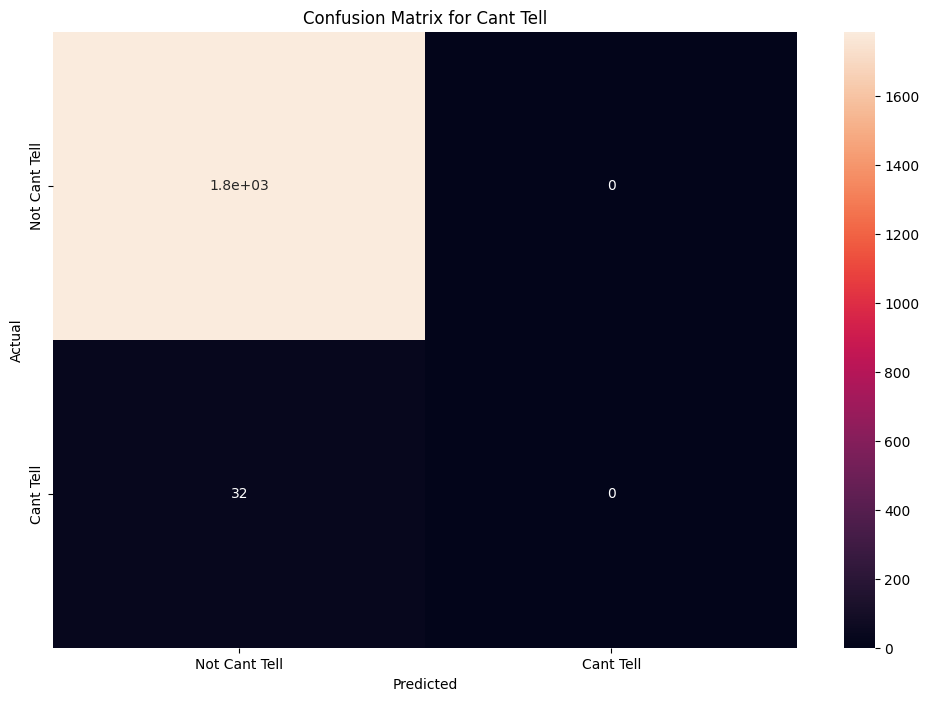

In [108]:
cm = multilabel_confusion_matrix(y_test, pipe_OVRC_lg_2.predict(X_test))

labels = ['No Emotion', 'Negative Emotion', 'Positive Emotion', 'Cant Tell']

for i, label in enumerate(labels):
    cm_df = pd.DataFrame(cm[i], index=[f'Not {label}', label], columns=[f'Not {label}', label])

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_df, annot=True)
    plt.title(f'Confusion Matrix for {label}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## **Conclusions**



*   **Conclusion 1:**  The emotion behind a tweet can be predicted based on the text.

*   **Conclusion 2:**  The model is better at predicting a lack of emotion than a positive or negative emotion.

*   **Conclusion 3:**  Companies can use a sentiment classifier to remove unemotional tweets and focus on positive and negative feedback.



### **Next Steps/Limitations**

*   **Next Step 1:**  This dataset was collecting tweets surround feedback from a specific event (South by Southwest Music festival in Austin, TX) during a specific time period.  This is good for developing a model for predicting feedback on this event but more data is needed to receive general feedback on the companies.

*   **Next Step 2:**  Add features targeted at specific products.  These data had missing data but if these weren't missing then we could create a model that specified feedback directed at these products and filter the feedback based on product type.

*   **Next Step 3:** Other platforms.  We could use the same ideas from this analysis and apply it to text from other forms of social media and see if there are other platforms where different types of feedback are expressed disproportionally than others so companies can focus their resources on those platforms.